In [4]:
# load the image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
from Dataloaders import dataloader_cifar10
from Models import gatedmodel, mobilenetv2, resnet
from Utils import utils
import torch
import matplotlib.pyplot as plt

train, test, val = dataloader_cifar10.Dataloader_cifar10_val()
client, server = mobilenetv2.mobilenetv2_splitter(weight_root='./Weights/cifar-10/', num_classes=10)
client2, server2 = resnet.resnet_splitter(weight_root='./Weights/cifar-10/', num_classes=10, layers=50)
# get the client out 
client = client.cuda()
client2 = client2.cuda()
client.eval()
client2.eval()

server = server.cuda()
server2 = server2.cuda()
server.eval()
server2.eval()

rate = [x/31 for x in range(32)]
rate2 = [x/63 for x in range(64)]
accuracy = []
accuracy2 = []

for ind, (img, label) in enumerate(val):
    img = img.cuda()
    label = label.cuda()
    break
with torch.no_grad():
    out = client(img).detach()
    out2 = client2(img).detach()

# rank the output with zeros
c_rank_non = utils.ranker_zeros(out, 0, 0.5)
c_rank_non2 = utils.ranker_zeros(out2, 0, 0.5)

c_act = np.zeros((128,32))
c_act_non = np.zeros((128,32))
for i in range(128):
    for j in range(32):
        c_act_non[i,c_rank_non[i,j]] = (31-j)/31

c_act2 = np.zeros((128,64))
c_act_non2 = np.zeros((128,64))
for i in range(128):
    for j in range(64):
        c_act_non2[i,c_rank_non2[i,j]] = (63-j)/63
                                     

# plot the channel activation
# hist plot
c_act_mean = np.mean(c_act, axis=0)
c_act_non_mean = np.mean(c_act_non, axis=0)
c_act_mean2 = np.mean(c_act2, axis=0)
c_act_non_mean2 = np.mean(c_act_non2, axis=0)

pred = server(out).detach()
pred = torch.argmax(pred, dim=1)
pred2 = server2(out2).detach()
pred2 = torch.argmax(pred2, dim=1)

pred_acc = torch.sum(pred == label).item()/128
pred_acc2 = torch.sum(pred2 == label).item()/128
pred_x = [x/32 for x in range(32)]
pred_x2 = [x/64 for x in range(64)]

Files already downloaded and verified
Files already downloaded and verified


<Figure size 500x500 with 0 Axes>

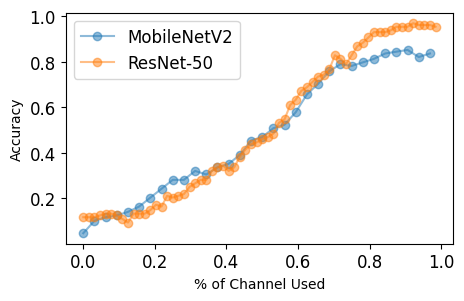

In [9]:
# second plot, use only one channel to see the effect
from Utils import utils

# plt.plot(pred_x, pred_order_accs, 'g--', label='Remove value < 0.1')

# plt.legend()


c_rank = utils.ranker_zeros(out, 0.1, 0.5)
for i in range(128):
    c_rank[i] = torch.flip(c_rank[i], dims=[0])
# reverse the c_rank
n_embs = [] #128,n,32,32 * 32
for j in range(32):
    n_emb = torch.zeros_like(out)
    for i in range(128):
        for k in range (j):
            n_emb[i,c_rank[i,k]] = out[i,c_rank[i,k]]
    n_embs.append(n_emb)
pred_orders = []
for n_emb in n_embs:
    pred_order = server(n_emb).detach()
    pred_order = torch.argmax(pred_order, dim=1)
    pred_orders.append(pred_order)
pred_order_accs = []
for pred_order in pred_orders:
    pred_order_acc = torch.sum(pred_order == label).item()/128
    pred_order_accs.append(pred_order_acc)

c_rank2 = utils.ranker_zeros(out2, 0.1, 0.5)
for i in range(128):
    c_rank2[i] = torch.flip(c_rank2[i], dims=[0])
# reverse the c_rank
n_embs2 = [] #128,n,32,32 * 32
for j in range(64):
    n_emb = torch.zeros_like(out2)
    for i in range(128):
        for k in range (j):
            n_emb[i,c_rank2[i,k]] = out2[i,c_rank2[i,k]]
    n_embs2.append(n_emb)
pred_orders2 = []
for n_emb in n_embs2:
    pred_order = server2(n_emb).detach()
    pred_order = torch.argmax(pred_order, dim=1)
    pred_orders2.append(pred_order)
pred_order_accs2 = []
for pred_order in pred_orders2:
    pred_order_acc = torch.sum(pred_order == label).item()/128
    pred_order_accs2.append(pred_order_acc)
plt.figure(figsize=(5,3))
plt.plot(pred_x, pred_order_accs, 'o-', label='MobileNetV2', alpha=0.5)
plt.plot(pred_x2, pred_order_accs2, 'o-', label='ResNet-50', alpha=0.5)
# scatter plot
# plt.scatter(pred_x, pred_order_accs, c='orange', marker='x')
plt.xlabel('% of Channel Used')
plt.ylabel('Accuracy')
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize = 12)

plt.savefig('./Plots/Channel_Accuracy.pdf')
# add the zerocount of each channel, examples
plt.show()
# plot Q3: using the number of number